<a href="https://colab.research.google.com/github/Pikarz/tirocinio_infostud/blob/main/extract_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estrazione labels

Oggi 02/08/23 inizio a estrarre le labels delle anomalie che mi ha consegnato Enrico. Tali labels saranno utile per effettuare il training dei modelli OC-SVM e ARMA e di calcolare i valori di precision, recall e F1 di MSCRED.

Tutti i file hanno una struttura tipo:

---
title: *name that expresses the details of the anomaly*

date: *date start anomaly*

resolved: *boolean*

resolvedWhen: *date anomaly end*

severity: *kind of severity (ie server was down)*

affected:

  - *list of affected services*
---


#Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# Estrazione lista tempi anomalie



In questi pezzi di codice, dato il path di un file che rappresenta un'anomalia riscontrata, estraggo i suoi tempi di inizio e fine.

In [ ]:
file = './drive/MyDrive/Uni/Terzo Anno/Tirocinio/colab/issues/2018-12-13_guasto_prenotazioni.md'

In [ ]:
import datetime
import time

# Function to convert date string to Unix timestamp
def convert_to_unix_timestamp(date_str):
    dt = datetime.datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    return int(time.mktime(dt.timetuple()))

# Function to extract metadata from .md file
def extract_metadata(file_path):
    with open(file_path, 'r') as file:
        return file.read()

In [ ]:

# Function to extract time range from a single .md file
def extract_time_range_from_md_file(file_path):
    metadata = extract_metadata(file_path)

    # Extract the start and end dates from the metadata
    start_date_str = metadata.split("date: ")[1].split("\n")[0].strip()
    end_date_str = metadata.split("resolvedWhen: ")[1].split("\n")[0].strip()

    # Convert start and end dates to Unix timestamps
    start_timestamp = convert_to_unix_timestamp(start_date_str)
    end_timestamp = convert_to_unix_timestamp(end_date_str)

    return (start_timestamp, end_timestamp)


In [ ]:
# test
extract_time_range_from_md_file(file)

(1544698740, 1544742000)

Ora generalizzo il concetto a più files, servendomi della funzione sopra

In [ ]:
# Function to create time range pairs (start, end) from multiple .md files
def extract_time_ranges_from_md_files(md_files):
    time_ranges = []

    for file_path in md_files:
        time_range = extract_time_range_from_md_file(file_path)
        time_ranges.append(time_range)

    return time_ranges

In [ ]:
import os

# Example usage:
# Provide the directory containing all the .md files
md_directory = "./drive/MyDrive/Uni/Terzo Anno/Tirocinio/colab/issues"
md_files = [os.path.join(md_directory, file) for file in os.listdir(md_directory) if file.endswith(".md")]

time_ranges = extract_time_ranges_from_md_files(md_files)

In [ ]:
len(time_ranges) # there are 102 .md files

102

In [ ]:
time_ranges

[(1568919180, 1568939160),
 (1563797220, 1563799500),
 (1571162400, 1571240760),
 (1557341160, 1557356400),
 (1610716140, 1610718480),
 (1607810400, 1607900400),
 (1592218740, 1592219220),
 (1568759280, 1568792400),
 (1544698740, 1544742000),
 (1569262020, 1569262500),
 (1548243720, 1548245220),
 (1609590300, 1609599600),
 (1592987580, 1593004860),
 (1557153000, 1557158400),
 (1551709800, 1551713400),
 (1575469800, 1575473400),
 (1558535400, 1558539000),
 (1568212200, 1568215800),
 (1580308200, 1580311800),
 (1576679400, 1576683000),
 (1576074600, 1576078200),
 (1586192400, 1586194200),
 (1558967400, 1558974600),
 (1562596200, 1562599800),
 (1557930600, 1557934200),
 (1598455800, 1598459400),
 (1592836200, 1592843400),
 (1601303400, 1601308800),
 (1561386600, 1561390200),
 (1598886000, 1598889600),
 (1571668200, 1571671800),
 (1560954600, 1560958200),
 (1574865000, 1574868600),
 (1588689000, 1588692600),
 (1560349800, 1560353400),
 (1585846800, 1585848600),
 (1559572200, 1559575800),
 

# Load Time Series
Funzione che estrae le time series da un tipo specifico di file. L'implementazione è spiegata nel file ```OC-SVM.ipynb```. Questa implementazione ha aggiunto anche la possibilità di scegliere in un intervallo di date specifico.

In [ ]:
import os
import glob
import pandas as pd
from datetime import datetime

def load_time_series(path, features, file_types, from_date=None, to_date=None, max_files=1, convert_to_timestamp=False, intersection=True):
    df_all_files = []
    file_counter = 0

    for file_type in file_types:
        json_dir = os.path.join(path, file_type + '*.json')
        for file in sorted(glob.glob(json_dir)):
            if file_counter >= max_files:
                break

            # Extract date and time substring
            date_time_str = str(file).split('_')[-1].split('.')[0]
            # Convert to datetime object
            file_date = datetime.strptime(date_time_str, '%Y-%m-%dT%H-%M-%S')

            try:
                # check if the date of the file is in the range of from_date and to_date
                if from_date is not None and file_date <= from_date:
                    continue
                if to_date is not None and file_date >= to_date:
                    continue

                print("Reading file " + file + "\n")
                df = pd.read_json(file)
                first_feature, remaining_features = features[0], features[1:]

                df_single_file = pd.DataFrame(df['data']['result'][first_feature]['values'])
                df_single_file.columns = ['timestamp', 'value' + str(first_feature)]
                df_single_file.set_index('timestamp', inplace=True)
                df_single_file['value' + str(first_feature)] = df_single_file['value' + str(first_feature)].astype(float)

                for i in remaining_features:
                    df_single_feature = pd.DataFrame(df['data']['result'][i]['values'])
                    df_single_feature.columns = ['timestamp', 'value' + str(i)]
                    df_single_feature.set_index('timestamp', inplace=True)

                    if intersection:
                        df_single_file = df_single_file.join(df_single_feature, how='inner')
                    else:
                        # Merge with alignment (asof merge) based on the nearest timestamp
                        df_single_file = pd.merge_asof(df_single_file, df_single_feature, on='timestamp', direction='nearest')

                        # Rename the columns to avoid conflicts when concatenating
                        df_single_file.rename(columns={'value' + str(i) + '_x': 'value' + str(first_feature),
                                                      'value' + str(i) + '_y': 'value' + str(i)}, inplace=True)

                    df_single_file['value' + str(i)] = df_single_file['value' + str(i)].astype(float)

                df_all_files.append(df_single_file)
                file_counter += 1
            except (IndexError, pd.errors.EmptyDataError):
                print("skipped\n")
                continue

    df_all_files = pd.concat(df_all_files)

    if convert_to_timestamp:
        # You may choose to skip this step if the timestamps are already in datetime format.
        df_all_files.index = pd.to_datetime(df_all_files.index, unit='s')

    return df_all_files


In [ ]:
path = './drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/'

filename = ['compat_http_responses_']
date_from = pd.to_datetime('2020-01-01')
date_to = pd.to_datetime('2020-05-01')

df_1 = load_time_series(path=path, from_date=date_from, to_date=date_to, features=[x for x in range(6)], file_types=filename, max_files=100, intersection=False)
df_1.plot()


Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2020-01-24T00-00-00.json

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2020-02-23T00-00-00.json

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2020-03-24T00-00-00.json



OSError: ignored

Estraggo tutte le osservazioni del file che riguarda le richieste http. Il range di date è il range più grande in cui non sono presenti reset

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2021-11-14T00-00-00.json

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2021-12-14T00-00-00.json

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2022-01-13T00-00-00.json

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2022-02-12T00-00-00.json

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2022-03-14T00-00-00.json

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2022-04-13T00-00-00.json



<Axes: xlabel='timestamp'>

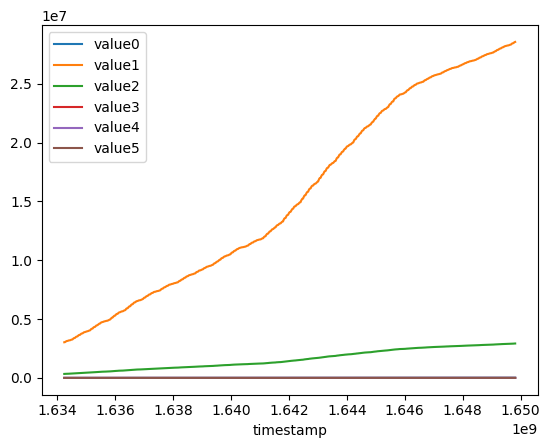

In [ ]:
path = './drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/'

filename = ['compat_http_responses_']
date_from = pd.to_datetime('2021-11-01')
date_to = pd.to_datetime('2022-05-01')

df_1 = load_time_series(path=path, from_date=date_from, to_date=date_to, features=[x for x in range(6)], file_types=filename, max_files=100, intersection=False)
df_1.plot()


Normalizzo

<Axes: xlabel='timestamp'>

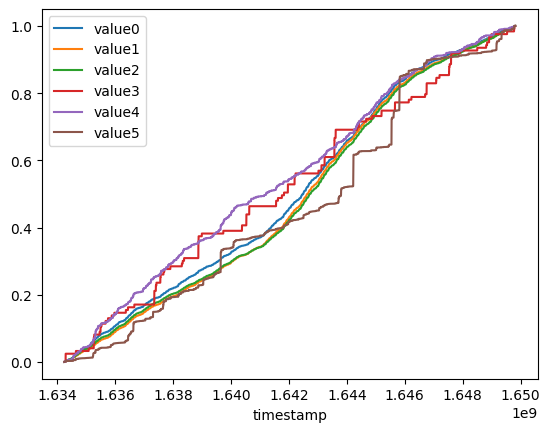

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Store the original index
original_index = df_1.index

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Drop the index, normalize the DataFrame using Min-Max scaling, and convert back to DataFrame
normalized_data = scaler.fit_transform(df_1.values)
normalized_df = pd.DataFrame(normalized_data, columns=df_1.columns)

# Set the original index back to the normalized DataFrame
normalized_df.index = original_index

normalized_df.plot()

In [ ]:
# sanity check: make sure that the number of observations are close to the number of 15-seconds windows that exist between the initial and last timestamps
import math

# Convert the first timestamp to datetime
first_timestamp_str = normalized_df.index[0]
first_timestamp_datetime = pd.to_datetime(first_timestamp_str, unit='s')
print("First Timestamp (datetime):", first_timestamp_datetime)

# Convert the last timestamp to datetime
last_timestamp_str = normalized_df.index[-1]
last_timestamp_datetime = pd.to_datetime(last_timestamp_str, unit='s')
print("Last Timestamp (datetime):", last_timestamp_datetime)

# Calculate the time duration between the two datetimes
time_duration = last_timestamp_datetime - first_timestamp_datetime

# Calculate the number of 15-second windows since the data is, usually, observed every 15 seconds.
seconds_in_15_seconds = 15
number_of_windows = int(time_duration.total_seconds() / seconds_in_15_seconds)
number_of_observations = normalized_df.shape[0]

print("Number of 15-second windows between the first and last timestamps:", number_of_windows)

print("Number of observations:", number_of_observations) # that's nice!
if abs(number_of_windows - number_of_observations) <= number_of_windows/100:
  print("The number of observations are close to the 15-second windows between the first and last timestamps!")
else:
  print("the number of observations doesn't seem right.")

First Timestamp (datetime): 2021-10-15 00:00:11.767000064
Last Timestamp (datetime): 2022-04-12 23:59:47.885999872
Number of 15-second windows between the first and last timestamps: 1036798
Number of observations: 1032672
The number of observations are close to the 15-second windows between the first and last timestamps!
